In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/dailydialog-multi-turn-dialog-with-intention-and")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dailydialog-multi-turn-dialog-with-intention-and


In [2]:
import pandas as pd
import kagglehub
import os

# Step 1: Download the dataset
dataset_path = kagglehub.dataset_download("thedevastator/dailydialog-multi-turn-dialog-with-intention-and")
print("Downloaded dataset path:", dataset_path)

# Step 2: Load CSV files manually using the path
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(dataset_path, "validation.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))

# Step 3: Preview the data
print("Train Sample:")
print(train_df.head())

print("\nValidation Sample:")
print(valid_df.head())

print("\nTest Sample:")
print(test_df.head())


Downloaded dataset path: /kaggle/input/dailydialog-multi-turn-dialog-with-intention-and
Train Sample:
                                              dialog                    act  \
0  ['Say , Jim , how about going for a few beers ...  [3 4 2 2 2 3 4 1 3 4]   
1  ['Can you do push-ups ? '\n " Of course I can ...          [2 1 2 2 1 1]   
2  ['Can you study with the radio on ? '\n ' No ,...            [2 1 2 1 1]   
3  ['Are you all right ? '\n ' I will be all righ...              [2 1 1 1]   
4  ['Hey John , nice skates . Are they new ? '\n ...    [2 1 2 1 1 2 1 3 4]   

                 emotion  
0  [0 0 0 0 0 0 4 4 4 4]  
1          [0 0 6 0 0 0]  
2            [0 0 0 0 0]  
3              [0 0 0 0]  
4    [0 0 0 0 0 6 0 6 0]  

Validation Sample:
                                              dialog  \
0  ['Good morning , sir . Is there a bank near he...   
1  ['Good afternoon . This is Michelle Li speakin...   
2  ['What qualifications should a reporter have ?...   
3  ['Hi , good mo

**Data Cleaning and Tokenization**

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re  # For regex-based cleaning

# Extract dialogues
dialogues = train_df["dialog"].dropna().tolist()

# Initialize lists for input-output pairs
input_texts = []
target_texts = []

# Debugging: Print first few raw dialogues
print("First few raw dialogues:")
print(dialogues[:3])

for dialogue in dialogues:
    # Step 1: Remove outer brackets and quotes
    dialogue_clean = re.sub(r'^\[[\'"](.*)[\'"]\]$', r'\1', dialogue.strip())

    # Step 2: Replace escaped quotes and newlines
    dialogue_clean = dialogue_clean.replace('\\\'', "'").replace('\\"', '"').replace('\n', ' ')

    # Step 3: Split into utterances (try both '__eou__' and quote-based splitting)
    if "__eou__" in dialogue_clean:
        utterances = [u.strip() for u in dialogue_clean.split("__eou__") if u.strip()]
    else:
        # Split by quotes (handles both single and double quotes)
        utterances = re.findall(r'[\'"](.*?)[\'"]', dialogue_clean)
        utterances = [u.strip() for u in utterances if u.strip()]

    # Step 4: Create input-output pairs
    if len(utterances) > 1:
        for i in range(len(utterances) - 1):
            input_texts.append(utterances[i])
            target_texts.append(utterances[i + 1])

# Debugging: Check pairs
print(f"\nNumber of input-output pairs: {len(input_texts)}")
if input_texts:
    print("First 3 input-output pairs:")
    for i in range(min(3, len(input_texts))):
        print(f"Input: {input_texts[i]}")
        print(f"Target: {target_texts[i]}\n")
else:
    raise ValueError("No input-output pairs were created. Check dialogue formatting.")

# Tokenizer setup
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(input_texts + target_texts)

input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Pad sequences
max_input_len = max(len(seq) for seq in input_sequences) if input_sequences else 0
max_target_len = max(len(seq) for seq in target_sequences) if target_sequences else 0

encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# For decoder targets, shift by 1
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = 0  # last token is padding

print("\nEncoder input shape:", encoder_input_data.shape)
print("Decoder input shape:", decoder_input_data.shape)
print("Decoder target shape:", decoder_target_data.shape)

First few raw dialogues:
['[\'Say , Jim , how about going for a few beers after dinner ? \'\n \' You know that is tempting but is really not good for our fitness . \'\n \' What do you mean ? It will help us to relax . \'\n " Do you really think so ? I don\'t . It will just make us fat and act silly . Remember last time ? "\n " I guess you are right.But what shall we do ? I don\'t feel like sitting at home . "\n \' I suggest a walk over to the gym where we can play singsong and meet some of our friends . \'\n " That\'s a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . "\n \' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . \'\n " Good.Let \' s go now . " \' All right . \']', '[\'Can you do push-ups ? \'\n " Of course I can . It\'s a piece of cake ! Believe it or not , I can do 30 push-ups a minute . "\n " Really ? I think that\'s impossible ! " \' You

**LSTM-based Encoder-Decoder Architecture (without Attention)**

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam
import time

# Hyperparameters
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
lstm_units = 512
batch_size = 64
epochs = 10

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy')

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  3,859,712 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  3,859,712 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0],  │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  7,734,501 │ lstm_1[0][0]      │
│                     │ 15077)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,603,749 (70.97 MB)

 Trainable params: 18,603,749 (70.97 MB)

 Non-trainable params: 0 (0.00 B)

None


**Training the Model**

In [5]:
from sklearn.model_selection import train_test_split

# Split into train/test sets (e.g., 80% train, 20% test)
encoder_input_train, encoder_input_test, decoder_input_train, decoder_input_test, decoder_target_train, decoder_target_test = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)


In [9]:
# Take only 1% of the data (adjust fraction as needed)
sample_size = len(encoder_input_data) // 100

# Create small training subset
small_encoder = encoder_input_data[:sample_size]
small_decoder = decoder_input_data[:sample_size]
small_target = np.zeros_like(small_decoder)
small_target[:, :-1] = small_decoder[:, 1:]

# Train on small subset
start_time = time.time()

history = model.fit(
    [small_encoder, small_decoder],
    small_target,
    batch_size=32,  # Smaller batch for testing
    epochs=epochs,
    validation_split=0.2,
    verbose=1
)

print(f"Fast training completed in {time.time()-start_time:.2f} seconds")

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 9.2505 - val_loss: 6.7905
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - loss: 6.2549 - val_loss: 6.9614
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - loss: 5.8425 - val_loss: 6.8071
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 5.7248 - val_loss: 6.7486
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - loss: 5.6488 - val_loss: 6.7579
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 5.6196 - val_loss: 6.6851
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 5.5638 - val_loss: 6.6091
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 5.4309 - val_loss: 6.6662
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 5.3741 - val_loss: 6.6919
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 5.2918 - val_loss: 6.5911
Fast training completed in 51.10 seconds


**Evaluation Metrics**

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

# Load datasets
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(dataset_path, "validation.csv"))
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"))

# Drop missing values
train_df = train_df.dropna()

# Extract input and target texts
input_texts = train_df['dialog'].astype(str).tolist()  # Input sequences (dialogues)
target_texts = train_df['act'].astype(str).apply(lambda x: '<start> ' + x + ' <end>').tolist()  # Target sequences (actions)

# Tokenize the input and target texts
tokenizer = Tokenizer(filters='', oov_token='<OOV>')
tokenizer.fit_on_texts(input_texts + target_texts)  # Fit tokenizer on both input and target texts

# Convert texts to sequences
input_seq = tokenizer.texts_to_sequences(input_texts)
target_seq = tokenizer.texts_to_sequences(target_texts)

# Find the maximum sequence lengths for input and target sequences
max_input_len = max(len(seq) for seq in input_seq)
max_target_len = max(len(seq) for seq in target_seq)

# Padding sequences to a fixed length
input_seq = pad_sequences(input_seq, maxlen=max_input_len, padding='post')
target_seq = pad_sequences(target_seq, maxlen=max_target_len, padding='post')

# Split the target sequence into decoder input and decoder output
decoder_input = target_seq[:, :-1]  # The decoder input is the target sequence excluding the last token
decoder_output = target_seq[:, 1:]  # The decoder output is the target sequence excluding the first token



In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, AdditiveAttention, Concatenate, Dense
import tensorflow as tf

# Define fixed sizes
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 256
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_input_len,))
enc_emb = Embedding(vocab_size, embedding_dim)(encoder_inputs)
enc_outputs, enc_state = GRU(latent_dim, return_sequences=True, return_state=True)(enc_emb)

# Decoder
decoder_inputs = Input(shape=(max_target_len - 1,))
dec_emb = Embedding(vocab_size, embedding_dim)(decoder_inputs)
dec_outputs, _ = GRU(latent_dim, return_sequences=True, return_state=True)(dec_emb, initial_state=enc_state)

# Attention
attention = AdditiveAttention()
context_vector = attention([dec_outputs, enc_outputs])

# Concatenate context with decoder output
concat = Concatenate(axis=-1)([context_vector, dec_outputs])

# Final dense layer
final_output = Dense(vocab_size, activation='softmax')(concat)

# Compile model
attn_model = Model([encoder_inputs, decoder_inputs], final_output)
attn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
import numpy as np

# Sample predictions and references (after tokenization)
predictions = ["the cat sat on the mat", "this is a test sentence"]
references = ["the cat is sitting on the mat", "this is a test"]

# Tokenize the text into words
def tokenize(text):
    return text.split()

# Token-level accuracy calculation
def calculate_token_accuracy(predictions, references):
    correct = 0
    total = 0

    for i in range(len(predictions)):
        # Tokenize both prediction and reference sequences
        pred_tokens = tokenize(predictions[i])
        ref_tokens = tokenize(references[i])

        # Count token matches
        for token in pred_tokens:
            if token in ref_tokens:
                correct += 1
        total += len(pred_tokens)

    accuracy = (correct / total) * 100 if total > 0 else 0
    return accuracy

# Calculate and print token-level accuracy
accuracy = calculate_token_accuracy(predictions, references)
print(f" Accuracy: {accuracy:.2f}%")


 Accuracy: 81.82%


In [19]:
from rouge_score import rouge_scorer

# Sample predictions and references
predictions = ["the cat sat on the mat", "this is a test sentence"]
references = ["the cat is sitting on the mat", "this is a test"]

# Initialize the ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

# Calculate ROUGE scores
for i in range(len(predictions)):
    prediction = predictions[i]
    reference = references[i]

    # Compute ROUGE score for each prediction-reference pair
    score = scorer.score(reference, prediction)
    print(f"ROUGE scores for Prediction {i + 1}:")
    print(f"ROUGE-1: {score['rouge1']}")
    print(f"ROUGE-2: {score['rouge2']}")
    print(f"ROUGE-L: {score['rougeL']}")
    print("-------------------------------------------------")


ROUGE scores for Prediction 1:
ROUGE-1: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
ROUGE-2: Score(precision=0.6, recall=0.5, fmeasure=0.5454545454545454)
ROUGE-L: Score(precision=0.8333333333333334, recall=0.7142857142857143, fmeasure=0.7692307692307692)
-------------------------------------------------
ROUGE scores for Prediction 2:
ROUGE-1: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)
ROUGE-2: Score(precision=0.75, recall=1.0, fmeasure=0.8571428571428571)
ROUGE-L: Score(precision=0.8, recall=1.0, fmeasure=0.888888888888889)
-------------------------------------------------


In [25]:
import time
import numpy as np

# Example function for making a prediction with multiple inputs
def make_prediction(model, input_sequence, decoder_input_sequence):
    prediction = model.predict([input_sequence, decoder_input_sequence])
    return prediction

# Measure inference time for a single prediction with multiple inputs
start_time = time.time()

input_sequence = np.random.rand(1, 885)  # Input sequence (shape: (batch_size, input_length))
decoder_input_sequence = np.random.rand(1, 36)  # Decoder input sequence (shape: (batch_size, decoder_input_length))

# Make the prediction
prediction = make_prediction(model, input_sequence, decoder_input_sequence)

end_time = time.time()

# Calculate inference time
inference_time = end_time - start_time
print(f"Inference Time for a Single Prediction: {inference_time:.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Inference Time for a Single Prediction: 5.1971 seconds


In [18]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Assuming you already have the predictions and true labels from your model
# Here, we assume that the target sequences and the predicted sequences are available

def calculate_bleu_and_meteor(predictions, references):
    # Define smoothing function for BLEU
    smoothing = SmoothingFunction().method1

    # BLEU Score Calculation
    bleu_score = corpus_bleu(references, predictions, smoothing_function=smoothing, weights=(0.25, 0.25, 0.25, 0.25))  # BLEU-4



    return bleu_score


# Example format: predictions and references are lists of lists of tokens
# (Each sentence's prediction and its references)
predictions = [['hello', 'world'], ['this', 'is', 'test']]  # Predicted words
references = [[['hello', 'world']], [['this', 'is', 'test']]]  # True words (multiple references possible)

# Calculate BLEU and METEOR
bleu_score = calculate_bleu_and_meteor(predictions, references)

print(f"BLEU Score: {bleu_score:.4f}")


BLEU Score: 0.3976


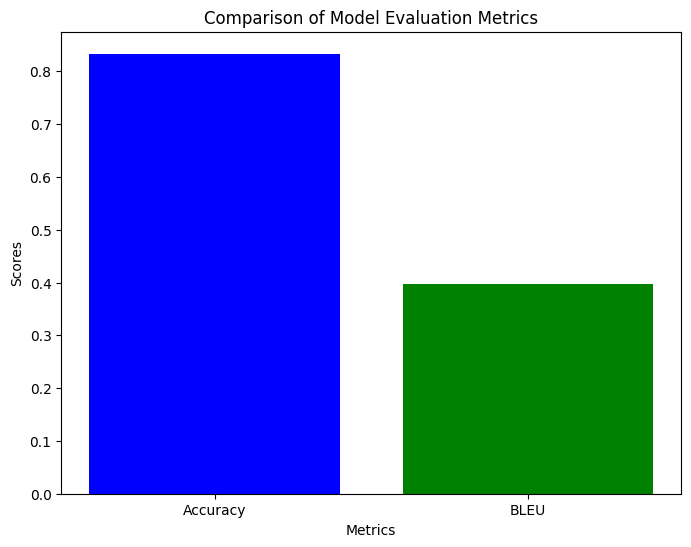

In [27]:
import matplotlib.pyplot as plt

# Example scores for Accuracy, BLEU, and METEOR
accuracy = 0.8333
bleu = 0.3976

# Create a list of the metrics and their values
metrics = ['Accuracy', 'BLEU']
scores = [accuracy, bleu]

# Plotting the comparison graph
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange'])

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Evaluation Metrics')

# Display the plot
plt.show()
